In [1]:
RUNS = 10
data_path = "data/mnist_split"
data_path_p = f"data/mnist_split/{1}/"
p_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# gets gradients for a specific run and task 
def get_gradients_for_task(p, task_no, RUNS):
    data_path_p = f"data/mnist_split/{p}/"
    
    # Initialize lists to collect gradient arrays for each type
    gradients_data = []

    for run in range(RUNS):
        run_file_names = [
            data_path_p + f"run_{run}/ideal_grad_task_{task_no}/grad_layers.0.bias.npy",
            data_path_p + f"run_{run}/ideal_grad_task_{task_no}/grad_layers.0.weight.npy",
            data_path_p + f"run_{run}/ideal_grad_task_{task_no}/grad_output_layer.bias.npy",
            data_path_p + f"run_{run}/ideal_grad_task_{task_no}/grad_output_layer.weight.npy"
        ]
        
        # Load gradient data
        run_data = [np.load(fname) for fname in run_file_names]
        
        # Append the loaded arrays to the list
        gradients_data.append(run_data)

    return gradients_data

#gets ideal gradients for a specific task
def get_ideal_grad_for_task(task_no):
    data_path_p = f"data/mnist_split/1/"

    run_file_name1 = data_path_p + f"task_{task_no}/grad_layers.0.bias.npy"
    run_file_name2 = data_path_p + f"task_{task_no}/grad_layers.0.weight.npy"
    run_file_name3 = data_path_p + f"task_{task_no}/grad_output_layer.bias.npy"
    run_file_name4 = data_path_p + f"task_{task_no}/grad_output_layer.weight.npy"
        
    data1 = np.load(run_file_name1)
    data2 = np.load(run_file_name2)
    data3 = np.load(run_file_name3)
    data4 = np.load(run_file_name4)

    return data1, data2, data3, data4

#calculates for different metrics for two unflattened matrices. 
def calculate_metrics(actual, ideal):
    # Ensure both arrays have the same shape
    if actual.shape != ideal.shape:
        raise ValueError(f"Shape mismatch: {actual.shape} vs {ideal.shape}")
    
    metrics = {}
    actual_flat = actual.flatten()
    ideal_flat = ideal.flatten()

    # MSE
    metrics['MSE'] = np.mean((actual_flat - ideal_flat) ** 2)
    
    # RMSE
    metrics['RMSE'] = np.sqrt(metrics['MSE'])
    
    # MAE
    metrics['MAE'] = np.mean(np.abs(actual_flat - ideal_flat))
    
    # Cosine Similarity
    dot_product = np.dot(actual_flat, ideal_flat)
    norm_actual = np.linalg.norm(actual_flat)
    norm_ideal = np.linalg.norm(ideal_flat)
    metrics['Cosine Similarity'] = dot_product / (norm_actual * norm_ideal) if (norm_actual * norm_ideal) != 0 else 0
    
    # Euclidean Distance
    metrics['Euclidean Distance'] = np.linalg.norm(actual_flat - ideal_flat)
    
    return metrics

#averages matrices across runs
def average_metrics_across_runs(gradients_runs, ideal_gradients):


    metrics_names = ['MSE', 'RMSE', 'MAE', 'Cosine Similarity', 'Euclidean Distance']
    metrics_results = {metric: [] for metric in metrics_names}
    
    for run_gradients in gradients_runs:
        for i in range(len(run_gradients)):
            if run_gradients[i].shape == ideal_gradients[i].shape:
                metrics = calculate_metrics(run_gradients[i], ideal_gradients[i])
                for metric in metrics_names:
                    metrics_results[metric].append(metrics[metric])
    
    # Average the metrics across runs
    averaged_metrics = {metric: np.mean(values) if values else 0 for metric, values in metrics_results.items()}
    return averaged_metrics
    y

    concatenated_ideal = flatten_and_concatenate_gradients(ideal_gradients)
    differences = []

    for run_gradients in gradients_runs:
        concatenated_run = flatten_and_concatenate_gradients(run_gradients)
        difference = concatenated_run - concatenated_ideal
        differences.append(difference)
    
    # Calculate metrics for each difference and then average them
    metrics_list = [calculate_metrics(diff, np.zeros_like(diff)) for diff in differences]
    averaged_metrics = {metric: np.mean([m[metric] for m in metrics_list]) for metric in metrics_list[0]}
    
    return averaged_metrics

def compute_differences_and_average_with_std(gradients_runs, ideal_gradients):
    # This structure will hold metrics for each run, allowing calculation of std deviation
    run_metrics_list = []

    for run_gradients in gradients_runs:
        run_metrics = []
        for actual, ideal in zip(run_gradients, ideal_gradients):
            if actual.shape == ideal.shape:
                metrics = calculate_metrics(actual, ideal)
                run_metrics.append(metrics)
        run_metrics_list.append(run_metrics)
    
    # Calculate the average and standard deviation across runs
    averaged_metrics = []
    std_dev_metrics = []
    for layer_index in range(len(ideal_gradients)):
        layer_metrics = [run[layer_index] for run in run_metrics_list if len(run) > layer_index]
        averaged_layer_metrics = {metric: np.mean([lm[metric] for lm in layer_metrics]) for metric in layer_metrics[0]}
        std_dev_layer_metrics = {metric: np.std([lm[metric] for lm in layer_metrics], ddof=1) for metric in layer_metrics[0]}
        averaged_metrics.append(averaged_layer_metrics)
        std_dev_metrics.append(std_dev_layer_metrics)
    
    return averaged_metrics, std_dev_metrics
    # Initialize lists to hold the differences for each layer
    differences = [[] for _ in ideal_gradients]

    # Iterate over each run's gradients
    for run_gradients in gradients_runs:
        for i, (actual, ideal) in enumerate(zip(run_gradients, ideal_gradients)):
            # Only process if shapes match
            if actual.shape == ideal.shape:
                difference = actual - ideal
                differences[i].append(difference)

    # Average the differences, ensuring non-empty lists are handled
    averaged_differences = []
    for diff_list in differences:
        if diff_list:
            # Stack and average if there are elements to process
            stacked_diffs = np.stack(diff_list, axis=0)
            averaged_diffs = np.mean(stacked_diffs, axis=0)
            averaged_differences.append(averaged_diffs)
        else:
            # Handle empty lists by creating a placeholder of zeros with the shape of the ideal gradients
            averaged_differences.append(np.zeros_like(ideal_gradients[i]))

    return averaged_differences


    
    # Average the metrics across runs for each layer
    averaged_layer_metrics = {
        layer: {metric: np.mean(values) if values else 0 for metric, values in layer_metrics[layer].items()}
        for layer in layer_metrics
    }
    return averaged_layer_metrics

def compute_differences_and_average_concatenated_with_std(gradients_runs, ideal_gradients):
    concatenated_ideal = flatten_and_concatenate_gradients(ideal_gradients)
    run_metrics = []

    for run_gradients in gradients_runs:
        concatenated_run = flatten_and_concatenate_gradients(run_gradients)
        metrics = calculate_metrics(concatenated_run, concatenated_ideal)
        run_metrics.append(metrics)
    
    # Calculate average and standard deviation of metrics
    averaged_metrics = {metric: np.mean([rm[metric] for rm in run_metrics]) for metric in run_metrics[0]}
    std_dev_metrics = {metric: np.std([rm[metric] for rm in run_metrics], ddof=1) for metric in run_metrics[0]}
    
    return averaged_metrics, std_dev_metrics
    
#gets a stores differences for every layer
def get_difs_all_runs_layers(task_no):
    ideal = get_ideal_grad_for_task(task_no)
    dist1 = np.array([])
    dist2 = np.array([])
    dist3 = np.array([])
    dist4 = np.array([])

    for run in range(1, RUNS):
        gradient = get_gradients_for_task(p, task_no, run)
        print(gradient[1].type)
        distances = calculate_metrics(gradient, ideal)
        dist1 = dist1.stack(calculate_metrics(gradient[0], ideal[0]))
        dist2 = dist2.stack(calculate_metrics(gradient[1], ideal[1]))
        dist3 = dist3.stack(calculate_metrics(gradient[2], ideal[2]))
        dist4 = dist4.stack(calculate_metrics(gradient[3], ideal[3]))
        print(distances)
    
    return np.mean(dist1), np.mean(dist2), np.mean(dist3), np.mean(dist4)
        
#helper function
def flatten_and_concatenate_arrays(arrays_tuple):
    """Flatten each array in the tuple and concatenate them into a single array."""
    flattened_arrays = [arr.flatten() for arr in arrays_tuple]
    concatenated_array = np.concatenate(flattened_arrays)
    return concatenated_array

def flatten_and_concatenate_gradients(gradients):
    """Flatten and concatenate gradients from all layers."""
    concatenated_gradients = np.concatenate([g.flatten() for g in gradients if g.size > 0])
    return concatenated_gradients



In [3]:
task = 4
RUNS = 10
p = 0.1

data_path = "data/mnist_split"
data_path_p = f"data/mnist_split/{p}/"
p_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# grads =  get_gradients_for_task(p, 4, 10)


In [4]:
def plot_all_metrics(task_no, RUNS):
    p_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    
    fig, axs = plt.subplots(3, 3, figsize=(18, 12))
    fig.tight_layout(pad=3.0)
    fig.suptitle(f'Distance between gradients for task {task_no}', fontsize=16, y=1.02)
    
    y_min, y_max = float('inf'), float('-inf')
    
    ideal_gradients = get_ideal_grad_for_task(task_no)
    
    for i, p in enumerate(p_values):
        row = i // 3
        col = i % 3
        gradients_runs = get_gradients_for_task(p, task_no, RUNS)
        
        # This call needs to be updated to the version that computes std deviation
        averaged_metrics, std_dev_metrics = compute_differences_and_average_with_std(gradients_runs, ideal_gradients)
        
        ax = axs[row, col]
        # Now pass std_dev_metrics to the plotting function
        plot_metrics_for_p_with_std(p, averaged_metrics, std_dev_metrics, ax)
        
        y_min_temp, y_max_temp = ax.get_ylim()
        y_min = min(y_min, y_min_temp)
        y_max = max(y_max, y_max_temp)
    
    for ax in axs.flat:
        ax.set_ylim([y_min, y_max])
    
    plt.show()
    
def plot_metrics_for_p(p, metrics_input, ax):
    metrics_names = ['MSE', 'RMSE', 'MAE', 'Cosine Similarity', 'Euclidean Distance']
    
    # Determine if the input is a single dictionary (concatenated gradients) or a list of dictionaries (layer-by-layer)
    if isinstance(metrics_input, dict):  # Handling for a single dictionary (concatenated gradients)
        data_labels = ['Concatenated Gradients']
        metrics_values = {metric: [metrics_input.get(metric, 0)] for metric in metrics_names}
    elif isinstance(metrics_input, list) and all(isinstance(item, dict) for item in metrics_input):  # Handling for a list of dictionaries (layer-by-layer)
        data_labels = ['layer bias', 'layer weights', 'output bias', 'output weights']
        metrics_values = {metric: [] for metric in metrics_names}
        for metric in metrics_names:
            for layer_metrics in metrics_input:
                metrics_values[metric].append(layer_metrics.get(metric, 0))
    else:
        raise ValueError("Invalid input format for metrics_input")

    x = np.arange(len(data_labels))
    width = 0.15

    for i, metric in enumerate(metrics_names):
        ax.bar(x + i * width, metrics_values[metric], width, label=metric)

    ax.set_xlabel('Gradient Type')
    ax.set_ylabel('Metric Value')
    ax.set_title(f'Metrics for p={p}')
    ax.set_xticks(x + (width * len(metrics_names) / 2) - (width / 2))
    ax.set_xticklabels(data_labels)
    ax.legend()

# def plot_metrics_for_p_with_std(p, metrics_averaged, std_dev_metrics, ax):
    metrics_names = ['MSE', 'RMSE', 'MAE', 'Cosine Similarity', 'Euclidean Distance']
    
    # Check if metrics are given per layer or for the entire model
    if isinstance(metrics_averaged, dict):
        # Single dictionary scenario, adjust for concatenated metrics
        data_labels = ['Concatenated Gradients']
        num_metrics = len(metrics_names)
        x = np.arange(num_metrics)
        width = 0.15

        for i, metric in enumerate(metrics_names):
            avg_value = metrics_averaged.get(metric, 0)
            std_value = std_dev_metrics.get(metric, 0)
            ax.bar(x[i], avg_value, width, yerr=std_value, label=metric, capsize=5)
    
    else:
        # List of dictionaries scenario, adjust for layer-by-layer metrics
        data_labels = ['layer bias', 'layer weights', 'output bias', 'output weights']
        num_labels = len(data_labels)
        x = np.arange(num_labels)
        width = 0.15
        
        for i, metric in enumerate(metrics_names):
            avg_values = [m.get(metric, 0) for m in metrics_averaged]
            std_values = [s.get(metric, 0) for s in std_dev_metrics]
            # Adjust position for each metric to avoid overlapping
            pos = x + (i - (len(metrics_names)/2)) * width
            ax.bar(pos, avg_values, width, yerr=std_values, label=metric, capsize=5)

    ax.set_xlabel('Metrics')
    ax.set_ylabel('Metric Value')
    ax.set_title(f'Metrics for p={p}')
    ax.set_xticks(x)
    ax.set_xticklabels(data_labels)
    ax.legend()

def plot_metrics_for_p_with_std(p, metrics_averaged, std_dev_metrics, ax):
    metrics_names = ['MSE', 'RMSE', 'MAE', 'Cosine Similarity', 'Euclidean Distance']
    
    # Correctly handling both scenarios: layer-by-layer and concatenated gradients
    if isinstance(metrics_averaged, dict):  # Handling for concatenated gradients
        # Use metric names directly for the x-ticks in concatenated scenario
        x = np.arange(len(metrics_names))
        ax.bar(x, [metrics_averaged.get(metric, 0) for metric in metrics_names],
               yerr=[std_dev_metrics.get(metric, 0) for metric in metrics_names], 
               capsize=5, label=metrics_names)
        ax.set_xticks(x)
        ax.set_xticklabels(metrics_names)
    else:  # Handling for layer-by-layer scenario
        data_labels = ['layer bias', 'layer weights', 'output bias', 'output weights']
        num_labels = len(data_labels)
        x = np.arange(num_labels)
        width = 0.15
        
        for i, metric in enumerate(metrics_names):
            avg_values = [m.get(metric, 0) for m in metrics_averaged]
            std_values = [s.get(metric, 0) for s in std_dev_metrics]
            # Calculate positions to avoid overlapping bars
            pos = x + (i - len(metrics_names) / 2) * width + width / 2
            ax.bar(pos, avg_values, width, yerr=std_values, label=metric, capsize=5)
            
        ax.set_xticks(x)
        ax.set_xticklabels(data_labels)

    ax.set_xlabel('Metric Type')
    ax.set_ylabel('Metric Value')
    ax.set_title(f'Metrics for p={p}')
    ax.legend()

def plot_all_metrics_concatenated(task_no, RUNS):
    p_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    
    fig, axs = plt.subplots(3, 3, figsize=(18, 12))
    fig.tight_layout(pad=3.0)
    fig.suptitle(f'Distance between concatenated gradients for task {task_no}', fontsize=16, y=1.02)
    
    # Load or calculate the ideal gradients once before the loop
    ideal_gradients = get_ideal_grad_for_task(task_no)
    
    for i, p in enumerate(p_values):
        row = i // 3
        col = i % 3
        gradients_runs = get_gradients_for_task(p, task_no, RUNS)
        
        averaged_metrics, std_dev_metrics = compute_differences_and_average_concatenated_with_std(gradients_runs, ideal_gradients)
        
        ax = axs[row, col]
        # Pass the computed std_dev_metrics to the plotting function
        plot_metrics_for_p_with_std(p, averaged_metrics, std_dev_metrics, ax)
    
    plt.show()





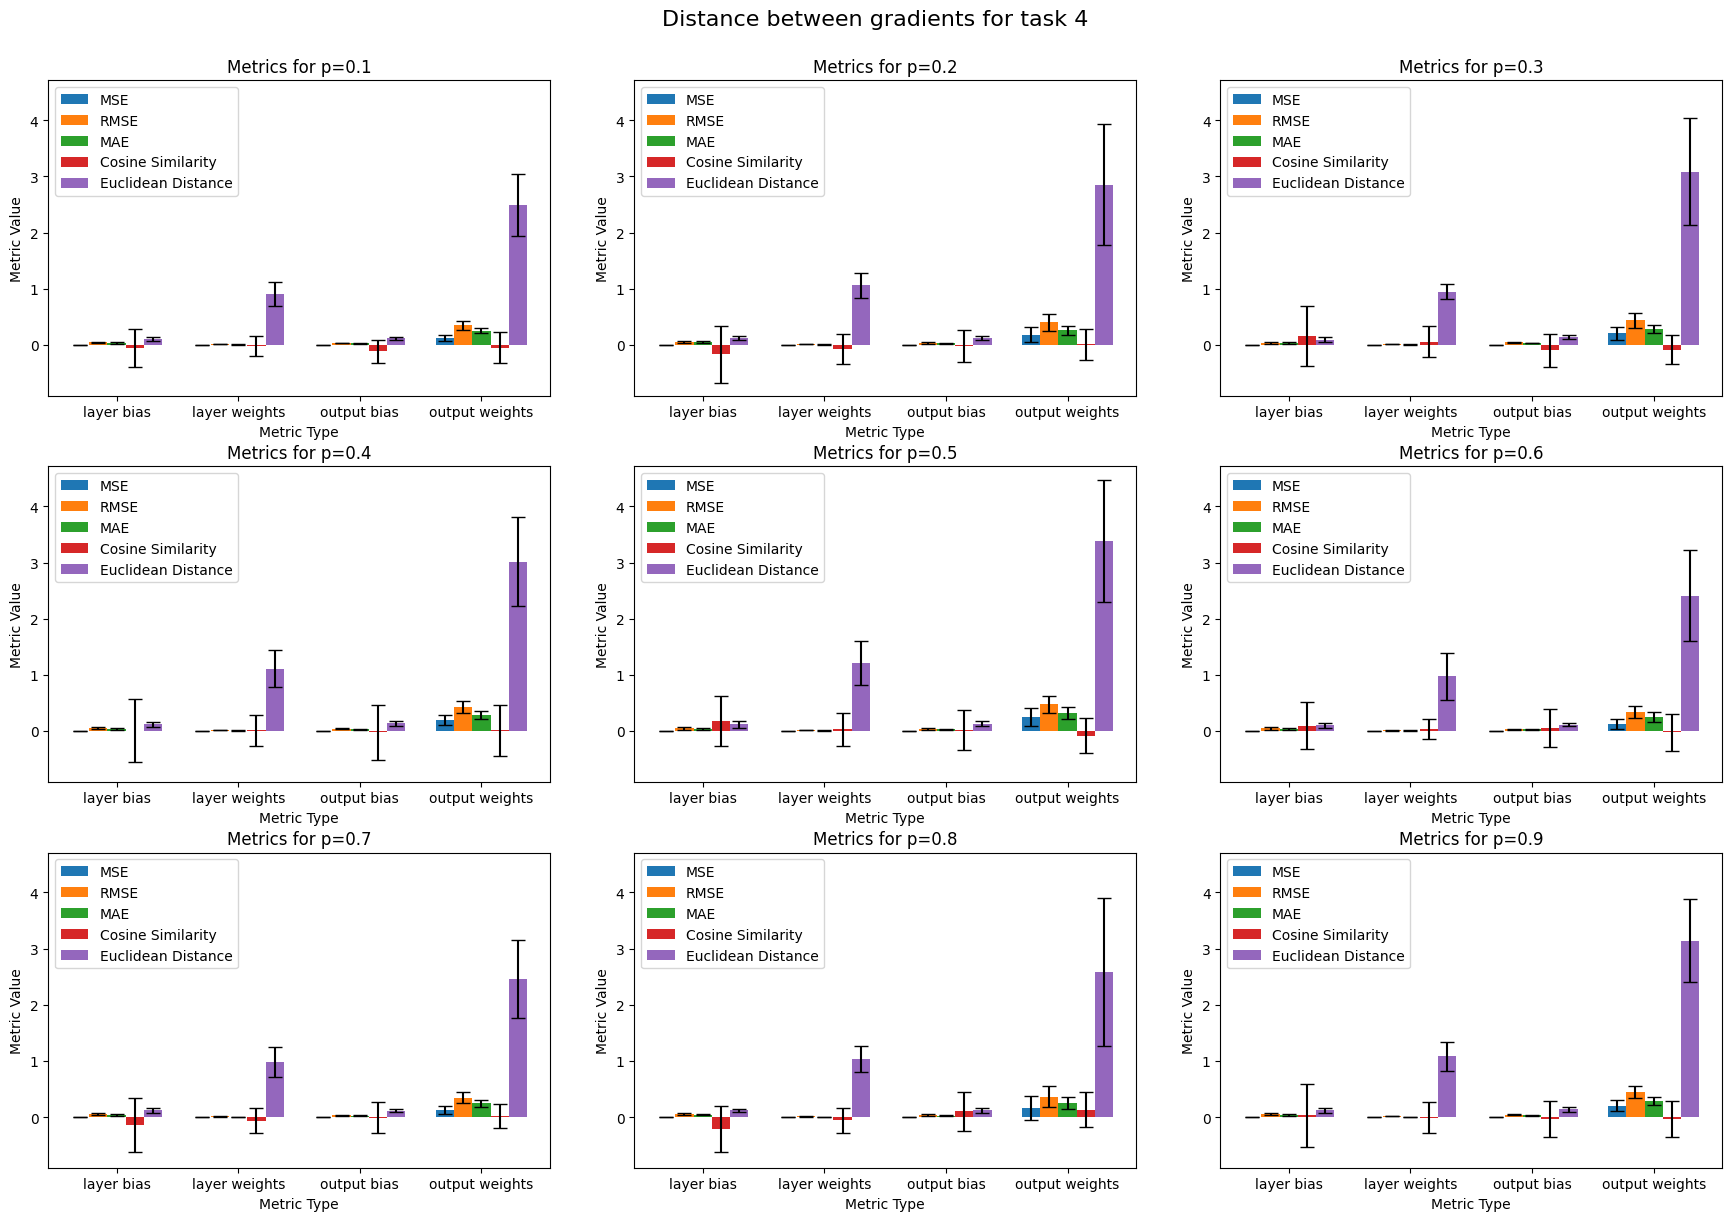

In [5]:
task = 4
plot_all_metrics(task, RUNS)

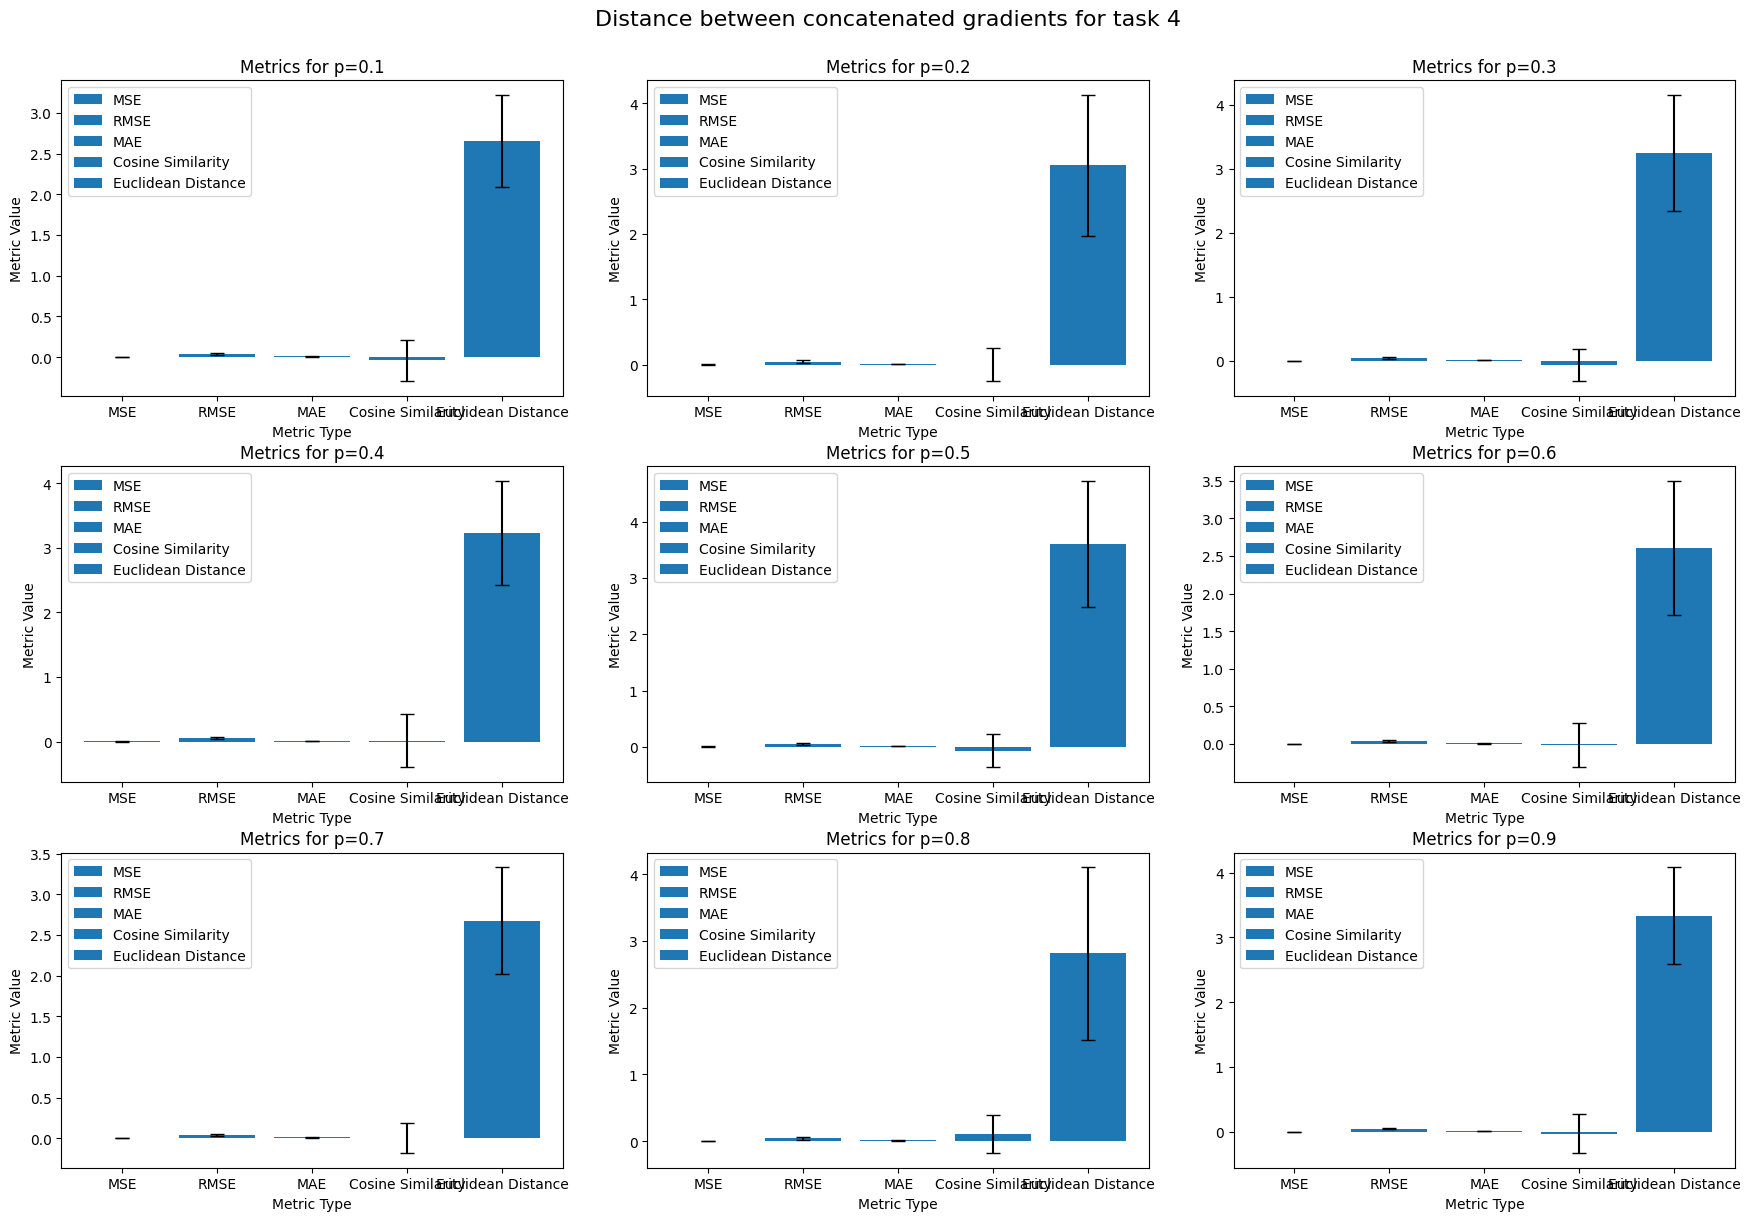

In [6]:
plot_all_metrics_concatenated(4, RUNS)